<a href="https://colab.research.google.com/github/dataforgoodfr/batch8_mednum/blob/master/notebooks/acces_information.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mini study to compare market rates to new bank grid granularity (end of 09/20 data)

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy.stats as SS
from scipy.interpolate import UnivariateSpline
from google.cloud import bigquery
import itertools
!pip install lmfit==1.0.1
from lmfit import Model


def get_percentile_rate(mu, sigma, percentile):
    """
    Compute percentile from lognormal distribution.

    Args:
        mu (float): mean
        sigma (float): std
        percentile (float between 0 and 1)
    """

    x = np.linspace(0, 3, 1000)
    y = SS.lognorm.cdf(x, loc=0, s=sigma, scale=mu)
    rt = x[np.where(y >= percentile)[0][0]]

    return rt


def interpolate_rates(data):
    """
    Interpolate the market rates and returns rate
    for a duration varying from 5 to 30 years.

    Args:
        data (pandas Dataframe): market rates per duration

    Returns:
        pandas Dataframe
    """

    rate_min, rate_max = 5, 30
    res = dict()

    # get mean and the three categories rates
    x, y_mean = data['duration'].apply(int), data['average_rate']
    y_exc = data.apply(lambda x: get_percentile_rate(
        x["average_rate"], x["sigma"], 0.2), axis=1)

    y_bon = data.apply(lambda x: get_percentile_rate(
        x["average_rate"], x["sigma"], 0.4), axis=1)
    y_ord = data.apply(lambda x: get_percentile_rate(
        x["average_rate"], x["sigma"], 0.8), axis=1)

    # interpolation
    xs = np.arange(rate_min, rate_max+1, 1)
    res['duration'] = xs
    for rate, name in zip([y_mean, y_exc, y_bon, y_ord],
                          'moyen excellent bon ordinaire'.split()):
        spl = UnivariateSpline(x, rate, k=3)           # interpolation
        ys = spl(xs)
        res[name] = ys

    res = pd.DataFrame.from_dict(res)
    #res['date'] = data['execution_date'][0].to_pydatetime().strftime('%Y-%m-%d')
    res['execution_date'] = str(datetime.datetime.today().timestamp())
    res = res[['execution_date', 'duration',
               'excellent', 'bon', 'moyen', 'ordinaire']]

    return res


def log_normal(x, mu, sigma):
    """
    Log-normal distibution (x, mu, sigma).

    Note
    ----

    x array and mu must be positive
    """
    assert x.all() > 0, 'All x values must be strictly positive !'
    if mu <= 0 or np.isnan(mu):
        return np.tile(np.nan, len(x))

    if sigma <= 0 or np.isnan(sigma):
        return np.tile(np.nan, len(x))

    return (1/(np.sqrt(2*np.pi) * x * sigma) * np.exp(-0.5 * ((np.log(x) - np.log(mu))/sigma)**2))


def get_data_histo(data, bins=15):
    """
    Return the middle of bins as x and histograms heights as y.
    """

    n, bins = np.histogram(data, bins=bins, density=True)    
    # get middle coordinates from bins hist
    mid = np.array([(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])])
    
    return mid, n


def fit_distrib(data, fit_function=log_normal, bins=15, ax=None,
                guess_mu=1.1, guess_sigma=0.2, print_fit=True, 
                plot_fit=None):
    """
    Fit the rate distribution with a log_normal (default function)
    and returns the mean and sigma with (is desired) goodness of fit.

    Parameters
    ----------
    data : array_like converted into an histogram
        Array of data to fit.
    fit_function: function
        Mathematical use as the objective function (default is log_normal).
    bins : int
        Number of bins used to generate the histogram of the data-array 
        (default is False).
    guess_mu: float
        Guess value for the mean of the distribution.
    guess_sigma: float
        Guess value for the sigma of the distribution.

    Returns
    -------
    mu : float
        Fitted mean value.
    sigma : float
        Fitted sigma value.
    print_fit: str
        Goodness of the fit (errors, chi2, AIC, BIC). 
    """ 

    # remove outliers using interquartile method
    zscores = SS.zscore(data)
    data = data[zscores <= 3]

    x, y = get_data_histo(data, bins=bins)      # get (x,y)
    
    # Fitting
    model = Model(fit_function)
    pars = model.make_params()
    pars['mu'].set(value=guess_mu, min=0.3, max=3)
    pars['sigma'].set(value=guess_sigma, min=0.02, max=1)

    init = model.eval(pars, x=x)
    fitter = model.fit(y, pars, x=x)

    if print_fit:
        print(fitter.fit_report())

    # Best values
    mu, sigma = fitter.best_values.values()
    # Plot
    if plot_fit:
        best_fit = log_normal(x, mu, sigma)
        if ax is None:
            fig, ax = plt.subplots()
        ax.hist(data, density=True, bins=bins)
        ax.plot(x, best_fit, label='Fit ' + fit_function.__name__, lw=2.5)
        ax.set(xlabel='taux', title='Distribution des taux')
        ax.legend(loc='upper right')

        s = []
        names = '$\mu$ $\sigma$'.split()
        for (name, value) in zip(names, [mu, sigma]):
            s.append("%s = %.3f" % (name, value))

        s = '\n'.join(s)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
        ax.text(0., 0.99, s, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=props)

    return mu, sigma


durations = [d for d in [10, 15, 20, 25]]
dates = [datetime.date.today().replace(day=1).strftime("%Y-%m-%d")]
keys = ['date', 'duration']
rates = [dict(zip(keys, combo)) for combo in itertools.product(
    dates, 
    durations
)]

def get_params_grid(row, grid):

    data = grid[
        (grid["duration"] == row["duration"])
    ]

    if len(data) > 20:
        mu, sigma = fit_distrib(data['rate'], print_fit=False)
    else:
        mu, sigma = None, None

    res = dict(row, **{
        "source": "bank_grids",
        "average_rate": mu,
        "sigma": sigma
    })

    return res


def bank_grids_rates(data):
    res = [get_params_grid(record, data) for record in rates]

    return res

In [ ]:
%%bigquery market --project pretto-apis

SELECT
date,
execution_date,
(duration / 12) as duration,
average_rate,
rate_20 as excellent,
rate_40 as bon,
rate_80 as ordinaire,
sigma
FROM
`rates_data.market_rates`
WHERE
DATE(execution_date) = '2020-09-20'
ORDER BY duration

In [ ]:
df_market = interpolate_rates(market)
df_market.head()

,execution_date,duration,excellent,bon,moyen,ordinaire
0,1602003244.356053,5,0.462462,0.546547,0.599082,0.774775
1,1602003244.356053,6,0.536072,0.620733,0.668646,0.836372
2,1602003244.356053,7,0.600048,0.686342,0.731068,0.894462
3,1602003244.356053,8,0.655447,0.744288,0.787106,0.949381
4,1602003244.356053,9,0.703327,0.795483,0.837522,1.001465


### Get distribution from new bank grid granularity

In [ ]:
%%bigquery grid --project pretto-apis
   
SELECT
date,
loan_duration / 12 as duration,
(base_rate-discount) as rate
FROM
`pretto-apis.metabase.bank_grids`
WHERE DATE(date) >= '2020-09-25'

In [ ]:
print(f'Bank grid shape from end of 09/20 : {grid.shape}')
grid.head()

Bank grid shape from end of 09/20 : (134952, 3)


,date,duration,rate
0,2020-09-25,10.0,1.38
1,2020-09-25,10.0,1.38
2,2020-09-25,10.0,1.38
3,2020-09-25,10.0,1.38
4,2020-09-25,10.0,1.38


In [ ]:
df_grid = pd.DataFrame(bank_grids_rates(grid))
df_grid

,date,duration,source,average_rate,sigma
0,2020-10-01,10,bank_grids,1.049591,0.298824
1,2020-10-01,15,bank_grids,1.221136,0.271961
2,2020-10-01,20,bank_grids,1.378075,0.243138
3,2020-10-01,25,bank_grids,1.589835,0.194676


In [ ]:
df_grid = interpolate_rates(df_grid)
#df_grid.head()

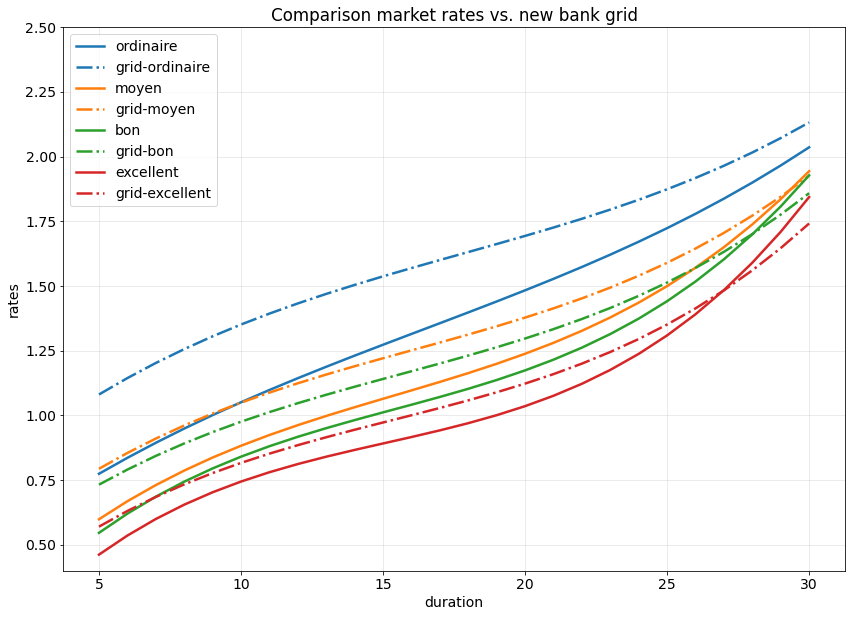

In [ ]:
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(14,10))
for col in 'ordinaire moyen bon excellent'.split():
  line, = ax.plot(df_market['duration'], df_market[col], label=col, lw=2.5)
  ax.plot(df_grid['duration'], df_grid[col], label=f'grid-{col}', color=line.get_color(), ls='-.', lw=2.5)

# settings
ax.legend(loc='upper left', fontsize='medium')
ax.set(ylim=[0.4, 2.5], xlabel='duration', ylabel='rates', title='Comparison market rates vs. new bank grid')
ax.grid(which='both', alpha=0.3)